# Predicting Collaboration Behavior
This notebook analyzes data collected from CoTrack (Audio and Logs) with the collaboration labels (Annotated by two raters, with cohen's kappa > substantial agreement)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import math

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Raw audio data for Group-1 from first school visit
raw_audio = librosa.load('sch1_group-1_single_channel.wav')

# Logs and Audio features (e.g. speaking time, speaking sequence, number of chars added or deleted)
features = pd.read_csv('sch1_group-1.csv')

# load audio for group-2
raw_audio2 = librosa.load('sch1_group-2_single_channel.wav')

# Logs and Audio features for group-2
features2 = pd.read_csv('sch1_group-2.csv')


In [3]:

# Collaboration labels for group-1
labels = pd.read_csv('coder2final.csv')


# Collaboration labels for group-2
labels2 = pd.read_csv('sch1_group-2_collaboration_scores.csv')



In [4]:
#print('Number of frames (30 sec each) for group-1:',features.shape[0],labels.shape[0])
#print('Number of frames (30 sec each) for group-2:',features2.shape[0],labels2.shape[0])
print('Total number of frames (30 sec):',(features2.shape[0]+features.shape[0]))
#features[['u1_add', 'u1_del', 'u2_add', 'u2_del','u3_add', 'u3_del', 'u4_add', 'u4_del', 'u1_speak', 'u2_speak', 'u3_speak','u4_speak']]

Total number of frames (30 sec): 121


## Computing Final Collaboration Scores

In [5]:
def computeFinalScore(rater1):
    rater1['ITO'] = (rater1['u1'] + rater1['u2'] + rater1['u3'] + rater1['u4'])/4
    rater1['final'] = 0
    for dim in ['SMU','CF','KE','ARG','STR','CO','ITO']:
        rater1['final'] = rater1['final'] + rater1[dim]
    return rater1['final']

In [6]:
labels['final'] = computeFinalScore(labels)
labels2['final'] = computeFinalScore(labels2)

total_collab = pd.concat([labels['final'],labels2['final']],axis=0,ignore_index=True)

In [7]:
total_collab.quantile([0.25,0.75])

0.25   -3.25
0.75    7.75
Name: final, dtype: float64

### Distribution of Collaboration Scores

Text(0.5, 1.0, 'Distibution of Collaboration Scores for both groups ')

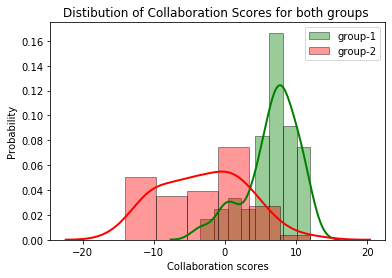

In [8]:
# Density Plot of Collboration Scores
plt.figure()
sns.distplot(labels['final'], hist=True, kde=True,  color = 'green', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2},label="group-1")
sns.distplot(labels2['final'], hist=True, kde=True,  color = 'red', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2},label="group-2")
plt.xlabel('Collaboration scores')
plt.ylabel('Probability')
plt.legend()
plt.title('Distibution of Collaboration Scores for both groups ')

Text(0.5, 1.0, 'Distibution of Collaboration Scores for group-1 ')

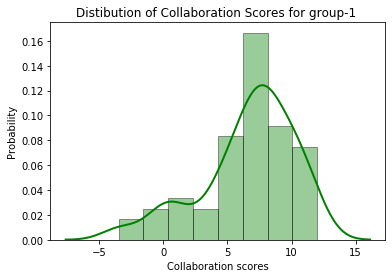

In [9]:
# Density Plot of Collboration Scores
plt.figure()
sns.distplot(labels['final'], hist=True, kde=True,  color = 'green', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
plt.xlabel('Collaboration scores')
plt.ylabel('Probability')

plt.title('Distibution of Collaboration Scores for group-1 ')

Text(0.5, 1.0, 'Distibution of Collaboration Scores for group-2')

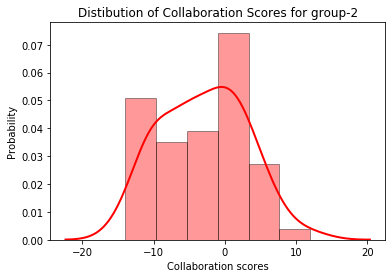

In [10]:
# Density Plot of Collboration Scores
plt.figure()
sns.distplot(labels2['final'], hist=True, kde=True,  color = 'red', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
plt.xlabel('Collaboration scores')
plt.ylabel('Probability')
plt.title('Distibution of Collaboration Scores for group-2')

## Computing group-level features
We have used three fusion techniques for mapping collected individual data into group-level measures. These techniques are 
 * Entropy based fusion
 * Dimensionality reduction fusion
 * Average based 
 
 Smith et al. [1] used Entropy-based fusion (Shanon entropy) to compute group-level features from individual features (30s time window).

### Entropy-based fusion
We computed three features at group-level (e.g., speaking time, characters added, and deleted) using Shanon Entropy.

In [19]:
# Computing Shanon Entropy for group-level features: Group-1

NO_USERS=4

features['group-speak'] = 0
features['group-no-speak'] = 0
features['group-add'] = 0
features['group-del'] = 0

for i in range(features.shape[0]):
    total_speak = features['u1_speak'] + features['u2_speak'] + features['u3_speak'] + features['u4_speak']
    total_add = features['u1_add'] + features['u2_add'] + features['u3_add'] + features['u4_add']
    total_del = features['u1_del'] + features['u2_del'] + features['u3_del'] + features['u4_del']
    
    entropy_spk = 0.0
    entropy_add = 0.0
    entropy_del = 0.0
    

    
    for j in range(NO_USERS):
        col_speak = 'u{}_speak'.format(str(j+1))
        col_add = 'u{}_add'.format(str(j+1))
        col_del = 'u{}_del'.format(str(j+1))
        
        
        
        
        
        # Entropy-based fusion
        
        if features.loc[i,col_speak] == 0:
            entropy_spk = entropy_spk + 0
        else:
            prob_spk = features.loc[i,col_speak]/(1.0*total_speak[i])
            entropy_spk = entropy_spk + prob_spk * math.log(1/prob_spk,2)
        
        if features.loc[i,col_add] == 0:
            entropy_add = entropy_add + 0
        else:
            prob_add = features.loc[i,col_add]/(1.0*total_add[i])
            entropy_add = entropy_add + prob_add * math.log(1/prob_add,2)
        
        if features.loc[i,col_del] == 0:
            entropy_del = entropy_del + 0
        else:
            prob_del = features.loc[i,col_del]/(1.0*total_del[i])
            entropy_del = entropy_del + prob_del * math.log(1/prob_del,2)

        
        
        
    features.loc[i,'group-speak'] = entropy_spk
    features.loc[i,'group-add'] = entropy_add
    features.loc[i,'group-del'] = entropy_del

In [20]:
# Computing Shanon Entropy for group-level features: Group-2

NO_USERS=4

features2['group-speak'] = 0
features2['group-no-speak'] = 0
features2['group-add'] = 0
features2['group-del'] = 0

for i in range(features2.shape[0]):
    total_speak = features2['u1_speak'] + features2['u2_speak'] + features2['u3_speak'] + features2['u4_speak']
    total_add = features2['u1_add'] + features2['u2_add'] + features2['u3_add'] + features2['u4_add']
    total_del = features2['u1_del'] + features2['u2_del'] + features2['u3_del'] + features2['u4_del']
    
    entropy_spk = 0.0
    entropy_add = 0.0
    entropy_del = 0.0
    

    
    for j in range(NO_USERS):
        col_speak = 'u{}_speak'.format(str(j+1))
        col_add = 'u{}_add'.format(str(j+1))
        col_del = 'u{}_del'.format(str(j+1))
        
        
        
        
        
        # Entropy-based fusion
        
        if features2.loc[i,col_speak] == 0:
            entropy_spk = entropy_spk + 0
        else:
            prob_spk = features2.loc[i,col_speak]/(1.0*total_speak[i])
            entropy_spk = entropy_spk + prob_spk * math.log(1/prob_spk,2)
        
        if features2.loc[i,col_add] == 0:
            entropy_add = entropy_add + 0
        else:
            prob_add = features2.loc[i,col_add]/(1.0*total_add[i])
            entropy_add = entropy_add + prob_add * math.log(1/prob_add,2)
        
        if features2.loc[i,col_del] == 0:
            entropy_del = entropy_del + 0
        else:
            prob_del = features2.loc[i,col_del]/(1.0*total_del[i])
            entropy_del = entropy_del + prob_del * math.log(1/prob_del,2)

        
        
        
    features2.loc[i,'group-speak'] = entropy_spk
    features2.loc[i,'group-add'] = entropy_add
    features2.loc[i,'group-del'] = entropy_del

### Average of individual-level feature

In [21]:
# Computing average for group-level features

NO_USERS=4

features['avg_group-speak'] = (features['u1_speak'] + features['u2_speak'] + features['u3_speak'] + features['u4_speak'])/4.0

features['avg_group-add'] = (features['u1_add'] + features['u2_add'] + features['u3_add'] + features['u4_add'])/4.0
features['avg_group-del'] = (features['u1_del'] + features['u2_del'] + features['u3_del'] + features['u4_del'])/4.0

# Group-2
features2['avg_group-speak'] = (features2['u1_speak'] + features2['u2_speak'] + features2['u3_speak'] + features2['u4_speak'])/4.0

features2['avg_group-add'] = (features2['u1_add'] + features2['u2_add'] + features2['u3_add'] + features2['u4_add'])/4.0
features2['avg_group-del'] = (features2['u1_del'] + features2['u2_del'] + features2['u3_del'] + features2['u4_del'])/4.0




A1 = pd.concat([features['avg_group-speak'],features['avg_group-add'],features['avg_group-del']], axis=1)
B1 = pd.concat([features2['avg_group-speak'],features2['avg_group-add'],features2['avg_group-del']], axis=1)
X_avg = pd.concat([A1,B1])


### Dimensionality Reduction based fusion

In [22]:
from sklearn.decomposition import PCA
import numpy as np

student_features = features[[ 'u1_add', 'u1_del', 'u2_add', 'u2_del','u3_add', 'u3_del', 'u4_add', 'u4_del','u1_speak', 'u2_speak', 'u3_speak','u4_speak']]
pca = PCA(n_components=4)
pca_features = pca.fit_transform(student_features)
print('Explained Variance group-1:',pca.explained_variance_ratio_.sum())

student_features2 = features2[[ 'u1_add', 'u1_del', 'u2_add', 'u2_del','u3_add', 'u3_del', 'u4_add', 'u4_del','u1_speak', 'u2_speak', 'u3_speak','u4_speak']]
pca2 = PCA(n_components=4)
pca_features2 = pca2.fit_transform(student_features2)
print('Explained Variance group-2:',pca2.explained_variance_ratio_.sum())

X_pca = np.concatenate((pca_features,pca_features2),axis=0)


Explained Variance group-1: 0.9853168560394207
Explained Variance group-2: 0.9366498472364618


## Preparing data for machine learning algorithms

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

In [24]:
# Adding features and collaboration labels from both groups

A = pd.concat([features['group-speak'],features['group-add'],features['group-del']], axis=1)
B = pd.concat([features2['group-speak'],features2['group-add'],features2['group-del']], axis=1)
X_ent = pd.concat([A,B])

## Exploring Classification 
We used 5-fold cross validation to train the machine learning model on training dataset.

In [25]:
from sklearn import metrics

# function to map collaboration score into two categories
def categ(x):
    if int(x) > 0:
        return 1
    else:
        return 0
    return 0

    
# Function to report various performance metrics
def performance_report(data_Y,predicted,label):
    print("#"*50)
    print("           ",label)
    print("#"*50)
    print ("accuracy",metrics.accuracy_score(data_Y, predicted))
    print ("f1 score macro",metrics.f1_score(data_Y, predicted, average='macro') )
    #print ("f1 score micro",metrics.f1_score(data_Y, predicted, average='micro') )
    print ("precision score",metrics.precision_score(data_Y, predicted, average='macro') )
    print ("recall score",metrics.recall_score(data_Y, predicted, average='macro') )
    #print ("hamming_loss",metrics.hamming_loss(data_Y, predicted))
    #print ("classification_report", metrics.classification_report(data_Y, predicted))
    #print ("jaccard_similarity_score", metrics.jaccard_similarity_score(data_Y, predicted))
    # print "log_loss", metrics.log_loss(data_Y, predicted)
    #print ("zero_one_loss", metrics.zero_one_loss(data_Y, predicted))
    # print "AUC&ROC",metrics.roc_auc_score(data_Y, predicted)
    # print "matthews_corrcoef", metrics.matthews_corrcoef(data_Y, predicted) 
    print("#"*50)
    print()

###

In [38]:
from sklearn.model_selection import cross_val_score

def exploreClassfication(X,y,label):
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
    print('#'*50)
    print('               ',label)
    print('#'*50)
    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025,random_state=20),
        SVC(gamma=2, C=1,random_state=20),
        GaussianProcessClassifier(1.0 * RBF(1.0),random_state=20),
        DecisionTreeClassifier(max_depth=5,random_state=20),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1,random_state=20),
        MLPClassifier(alpha=1, max_iter=1000,random_state=20),
        AdaBoostClassifier(random_state=20),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
    
    for name, clf in zip(names, classifiers):
        scores = cross_val_score(clf, X, y, cv=5)
        f1 = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
        print(name,' :',scores.mean(),' ',f1.mean())
    print('#'*50)

### Classification with two collaboration categories (High, Low)
We mapped collaboration score less than 0 as Low and score greater than 0 as High.

In [26]:
# Equally distributed classes  > 6
labels['class'] = labels['final'].map(categ)
labels2['class'] = labels2['final'].map(categ)

class_binary = pd.concat([labels['class'],labels2['class']],axis=0)
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_pca, class_binary, test_size=0.3, random_state=0)
print('training data:',X_train_binary.shape)
print('test data:',X_test_binary.shape)

training data: (84, 4)
test data: (37, 4)


#### Logistic regression without SMOTE

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

model = LogisticRegression().fit(X_train_binary,y_train_binary)

print(performance_report(y_test_binary,model.predict(X_test_binary),label="Logistic with two classes"))

##################################################
            Logistic with two classes
##################################################
accuracy 0.5945945945945946
f1 score macro 0.42724458204334365
precision score 0.55
recall score 0.5106060606060606
##################################################

None


#### Logistic regression with SMOTE

In [100]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_binary, y_train_binary)


model = LogisticRegression().fit(X_res,y_res)

print(performance_report(y_test_binary,model.predict(X_test_binary),label="Logistic with two classes with SMOTE"))

##################################################
            Logistic with two classes with SMOTE
##################################################
accuracy 0.40540540540540543
f1 score macro 0.3680124223602485
precision score 0.4435483870967742
recall score 0.4681818181818182
##################################################

None


#### Performance of Classification algorithms with group features (Entropy)

In [103]:
exploreClassfication(X,class_binary,'Entropy-fusion')

##################################################
                Entropy-fusion
##################################################
Nearest Neighbors  : 0.5526666666666666   0.5159947084330386
Linear SVM  : 0.5703333333333334   0.3631177736440894
RBF SVM  : 0.553   0.47598483950729487
Gaussian Process  : 0.5453333333333333   0.45281767144449103
Decision Tree  : 0.52   0.45547872293989844
Random Forest  : 0.561   0.5286994367639529
Neural Net  : 0.5280000000000001   0.42822785646702055
AdaBoost  : 0.52   0.5016782175954628
Naive Bayes  : 0.47833333333333333   0.35117113801324323
QDA  : 0.495   0.36186668555089607
##################################################


#### Performance of Classification algorithms with group features (PCA)

In [104]:
exploreClassfication(X_pca,class_binary,'PCA-fusion')

##################################################
                PCA-fusion
##################################################
Nearest Neighbors  : 0.6703333333333333   0.6239329039329039
Linear SVM  : 0.5703333333333334   0.3768035473298631
RBF SVM  : 0.736   0.6926932818393918
Gaussian Process  : 0.7036666666666667   0.6512930818813171
Decision Tree  : 0.6536666666666667   0.6176695967621557
Random Forest  : 0.6783333333333333   0.6111790686094091
Neural Net  : 0.7443333333333333   0.7151391434652303
AdaBoost  : 0.7193333333333334   0.6807435036149776
Naive Bayes  : 0.45499999999999996   0.41650759660051034
QDA  : 0.45499999999999996   0.41827433228028943
##################################################


#### Performance of Classification algorithms with group features (Average)

In [99]:
exploreClassfication(X_avg,class_binary,'Average')

##################################################
                Average
##################################################
Nearest Neighbors  : 0.46366666666666667   0.4381662781662782
Linear SVM  : 0.495   0.33656099708731285
RBF SVM  : 0.4050000000000001   0.327286208447733
Gaussian Process  : 0.4803333333333334   0.4268633115691939
Decision Tree  : 0.4373333333333333   0.37431111039523557
Random Forest  : 0.4136666666666667   0.3550436225218834
Neural Net  : 0.45533333333333337   0.4110517396285897
AdaBoost  : 0.4803333333333333   0.4234831623066918
Naive Bayes  : 0.4953333333333333   0.4038588565647389
QDA  : 0.5373333333333333   0.4556671283819095
##################################################


### Classification with three collaboration classes (High, Low, Medium)

To decide the boundary, we computed 25th and 75th quantiles of the collaboration scores and used them to assign categoreis.

    0.25   -3.25
    0.75    7.75
    Name: final, dtype: float64

In [56]:
# function to map collaboration score into three categories
def categ3(x):
    if int(x) > 6:
        return 2
    elif int(x) > 0:
        return 1
    else:
        return 0

(121,)
training data: (84, 4)
test data: (37, 4)


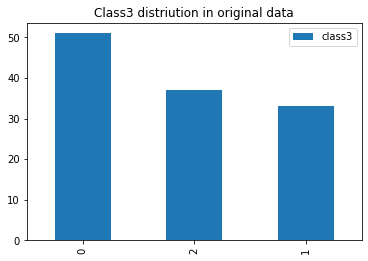

In [58]:
labels['class3'] = labels['final'].map(categ3)
labels2['class3'] = labels2['final'].map(categ3)

class_three = pd.concat([labels['class3'],labels2['class3']],axis=0)
print(class_three.shape)

X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(X_pca, class_three, test_size=0.3, random_state=0)
print('training data:',X_train_three.shape)
print('test data:',X_test_three.shape)

d = pd.DataFrame(class_three.value_counts())
d.plot(kind='bar')
plt.title('Class3 distriution in original data')
plt.show()

#### Logistic regression with three class

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

model = LogisticRegression(multi_class='ovr').fit(X_train_three,y_train_three)
print('Logistic Regression with three classes',model.score(X_test_three,y_test_three))
print(performance_report(y_test_three,model.predict(X_test_three),label="Logistic with three classes"))

Logistic Regression with three classes 0.3783783783783784
##################################################
            Logistic with three classes
##################################################
accuracy 0.3783783783783784
f1 score macro 0.18666666666666665
precision score 0.13333333333333333
recall score 0.3111111111111111
##################################################

None


#### Logistic regression with three classes after SMOTE

In [60]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_three, y_train_three)

model = LogisticRegression(multi_class='ovr').fit(X_res,y_res)
print('Logistic Regression with three classes',model.score(X_test_three,y_test_three))
print(performance_report(y_test_three,model.predict(X_test_three),label='logistic with three classes with smote'))

Logistic Regression with three classes 0.4864864864864865
##################################################
            logistic with three classes with smote
##################################################
accuracy 0.4864864864864865
f1 score macro 0.4342948717948718
precision score 0.44793802688539525
recall score 0.44558404558404563
##################################################

None


#### Classification performance for three classes (Entropy)

In [61]:
exploreClassfication(X_ent,class_three,'Entropy')

##################################################
                Entropy
##################################################
Nearest Neighbors  : 0.37133333333333335   0.3354118683249118
Linear SVM  : 0.4046666666666667   0.19279640171480777
RBF SVM  : 0.4046666666666667   0.3245151863387158
Gaussian Process  : 0.3963333333333333   0.23990980191359695
Decision Tree  : 0.3966666666666667   0.3404804130242726
Random Forest  : 0.421   0.36651489371570506
Neural Net  : 0.429   0.35853800249196666
AdaBoost  : 0.4293333333333333   0.4029836364260916
Naive Bayes  : 0.32966666666666666   0.27033644618245506
QDA  : 0.3463333333333333   0.29690489722459035
##################################################


#### Classification performance for three classes (Average)

In [62]:
exploreClassfication(X_avg,class_three,'Average')

##################################################
                Average
##################################################
Nearest Neighbors  : 0.2643333333333333   0.175181183818865
Linear SVM  : 0.45466666666666666   0.25620915032679736
RBF SVM  : 0.29733333333333334   0.21021262262641574
Gaussian Process  : 0.3973333333333333   0.2850970017636684
Decision Tree  : 0.28833333333333333   0.2249335631688573
Random Forest  : 0.264   0.2324608724608725
Neural Net  : 0.33899999999999997   0.25641702741702743
AdaBoost  : 0.25566666666666665   0.22257515904574726
Naive Bayes  : 0.2316666666666667   0.19780576504105915
QDA  : 0.23933333333333334   0.19636973193835938
##################################################


#### Classification performance for three classes (PCA)

In [63]:
exploreClassfication(X_pca,class_three,'PCA')

##################################################
                PCA
##################################################
Nearest Neighbors  : 0.43933333333333324   0.33743391760271557
Linear SVM  : 0.4213333333333334   0.19879183996831054
RBF SVM  : 0.4963333333333334   0.40558500323206204
Gaussian Process  : 0.5546666666666666   0.4322412788238698
Decision Tree  : 0.3896666666666667   0.3008890862224195
Random Forest  : 0.4383333333333333   0.35768593062710713
Neural Net  : 0.5543333333333333   0.44930961195667074
AdaBoost  : 0.48966666666666664   0.4190659710659711
Naive Bayes  : 0.36433333333333334   0.2204773541870316
QDA  : 0.31566666666666665   0.19606848141209993
##################################################


### Tuning hyper parameters for SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
Cs = [0.001, 0.01, 0.1, 1, 10,100]
gammas = [.0001,0.001, 0.01, 0.1, 1]
kernel_params = ['rbf','sigmoid','poly']
param_grid = {'C': Cs, 'gamma' : gammas, 'kernel':kernel_params}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train_binary, y_train_binary)
grid_search.best_params_
print(grid_search.best_params_)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
kernel_params = ['rbf','sigmoid','poly','gamma']
param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6),'kernel':kernel_params}

rand_search = RandomizedSearchCV(SVC(), param_grid, cv=5)
rand_search.fit(X_train_binary, y_train_binary)
rand_search.best_params_
print(rand_search.best_params_)

{'kernel': 'poly', 'gamma': 10.0, 'C': 0.01}


In [73]:
clf = SVC(gamma=10.0,kernel='poly',C=.01)
clf.fit(X_train_binary,y_train_binary)
print(performance_report(y_test_binary,clf.predict(X_test_binary),label='SVM rbf two classes'))

##################################################
            SVM rbf two classes
##################################################
accuracy 0.7297297297297297
f1 score macro 0.6916666666666667
precision score 0.746031746031746
recall score 0.6878787878787879
##################################################

None


In [81]:
clf = SVC(gamma='auto',kernel='rbf',C=.01)
clf.fit(X_train_three,y_train_three)
print(performance_report(y_test_three,clf.predict(X_test_three),label='SVM rbf three classes'))

##################################################
            SVM rbf three classes
##################################################
accuracy 0.40540540540540543
f1 score macro 0.1923076923076923
precision score 0.13513513513513514
recall score 0.3333333333333333
##################################################

None


In [80]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_three, y_train_three)


clf = SVC(gamma='auto',kernel='rbf')
clf.fit(X_res,y_res)

print(performance_report(y_test_three,clf.predict(X_test_three),label='SVM rbf three classes after SMOTE'))

##################################################
            SVM rbf three classes after SMOTE
##################################################
accuracy 0.5675675675675675
f1 score macro 0.4537037037037037
precision score 0.37777777777777777
recall score 0.5703703703703704
##################################################

None


### After SMOTE

In [82]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_binary, y_train_binary)


clf = SVC(gamma='auto',kernel='rbf')
clf.fit(X_res,y_res)
print('Support Vector Machine with two classes  (RBF kernel)',clf.score(X_test_binary,y_test_binary))
print(performance_report(y_test_binary,clf.predict(X_test_binary),label='SVM rbf two classes after SMOTE'))

Support Vector Machine with two classes  (RBF kernel) 0.7837837837837838
##################################################
            SVM rbf two classes after SMOTE
##################################################
accuracy 0.7837837837837838
f1 score macro 0.7533333333333334
precision score 0.8194444444444444
recall score 0.7439393939393939
##################################################

None


In [83]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_three, y_train_three)



mlp = MLPClassifier(alpha=1, max_iter=1000,random_state=20)
mlp.fit(X_res,y_res)
print('Support Vector Machine with two classes  (RBF kernel)',clf.score(X_test_three,y_test_three))
print(performance_report(y_test_three,clf.predict(X_test_three),label='Neural Net three classes after SMOTE'))

Support Vector Machine with two classes  (RBF kernel) 0.5405405405405406
##################################################
            Neural Net three classes after SMOTE
##################################################
accuracy 0.5405405405405406
f1 score macro 0.4173441734417344
precision score 0.43915343915343913
recall score 0.4854700854700855
##################################################

None


In [66]:

clf = SVC(C=10,gamma=.01,kernel='rbf',random_state=20)
scores = cross_val_score(clf, X_train_binary, y_train_binary, cv=5)
f1 = cross_val_score(clf, X_train_binary, y_train_binary, cv=5, scoring='f1_macro')
print('SVM :',scores.mean(),' ',f1.mean())
clf = SVC(C=10,gamma=.01,kernel='rbf',random_state=20)
clf.fit(X_train_binary, y_train_binary)

#print(performance_report(y_test_binary,clf.predict(X_test_binary),label='SVM rbf'))

y_test_three.value_counts()
chance_predict = np.zeros((37,1))


print(performance_report(y_test_three,chance_predict,label='Chance Prediction Accuracy with three clasess'))

SVM : 0.7838235294117647   0.7768939393939392
##################################################
            Chance Prediction Accuracy with three clasess
##################################################
accuracy 0.40540540540540543
f1 score macro 0.1923076923076923
precision score 0.13513513513513514
recall score 0.3333333333333333
##################################################

None


## Prediction accuracy for Sub-Dimensions of Collaboration
This sub-section investigate the accuracy of machine learning algorithm in predicting observed behavior on sub-dimensions of collaboration. We have divided score for each sub-dimension into three categories: High, Medium, and Low. Scores below zero are considered Low, and above zero as High. Zero is considered as medium.
Another version of this also taken where Low and Medium combined to have a single category.

In [84]:
def generateCategory(x):
    if int(x) > 0:
        return  1
    else:
        return 0

In [92]:
for dim in ['SMU','CF','KE','CO','STR','ITO','ARG']:
    A = pd.concat([labels[dim],labels2[dim]],axis=0)
    class_label = A.map(generateCategory)
    X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_pca, class_label, test_size=0.3, random_state=0)
    label = dim + 'Dimension'
    exploreClassfication(X_train_binary,y_train_binary,label)

##################################################
                SMUDimension
##################################################
Nearest Neighbors  : 0.725735294117647   0.7213818860877683
Linear SVM  : 0.5360294117647059   0.348923076923077
RBF SVM  : 0.8198529411764707   0.8171045260209346
Gaussian Process  : 0.7492647058823529   0.746750700280112
Decision Tree  : 0.7713235294117646   0.7703216374269006
Random Forest  : 0.7492647058823529   0.7392329239388064
Neural Net  : 0.7970588235294118   0.7905860805860806
AdaBoost  : 0.713235294117647   0.7059181607865818
Naive Bayes  : 0.4992647058823529   0.45522568773712935
QDA  : 0.6669117647058823   0.6401238712828429
##################################################
##################################################
                CFDimension
##################################################
Nearest Neighbors  : 0.6654411764705882   0.6432410726528374
Linear SVM  : 0.5595588235294118   0.3586096866096867
RBF SVM  : 0.676470588235294

In [94]:
for dim in ['SMU','CF','KE','CO','STR','ITO','ARG']:
    A = pd.concat([labels[dim],labels2[dim]],axis=0)
    class_label = A.map(generateCategory)
    X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_pca, class_label, test_size=0.3, random_state=0)
    label = dim + ' Dimension- Test accuracy and f1-score'
    clf = SVC(gamma=2, C=1,random_state=20)
    clf.fit(X_train_binary,y_train_binary)
    print(performance_report(y_test_binary,clf.predict(X_test_binary),label=label))


##################################################
            SMU Dimension- Test accuracy and f1-score
##################################################
accuracy 0.7567567567567568
f1 score macro 0.7161125319693094
precision score 0.7638888888888888
recall score 0.7065217391304348
##################################################

None
##################################################
            CF Dimension- Test accuracy and f1-score
##################################################
accuracy 0.7567567567567568
f1 score macro 0.7501875468867216
precision score 0.7624223602484472
recall score 0.7485294117647059
##################################################

None
##################################################
            KE Dimension- Test accuracy and f1-score
##################################################
accuracy 0.7837837837837838
f1 score macro 0.7412587412587412
precision score 0.7817460317460317
recall score 0.7275641025641025
#################################

In [88]:
exploreClassfication(X,class_binary,'Entropy fusion')

##################################################
                Entropy fusion
##################################################
Nearest Neighbors  : 0.47833333333333333   0.44249613824704576
Linear SVM  : 0.5703333333333334   0.3631177736440894
RBF SVM  : 0.553   0.47598483950729487
Gaussian Process  : 0.5453333333333333   0.45281767144449103
Decision Tree  : 0.52   0.45547872293989844
Random Forest  : 0.561   0.5286994367639529
Neural Net  : 0.5280000000000001   0.42822785646702055
AdaBoost  : 0.52   0.5016782175954628
Naive Bayes  : 0.47833333333333333   0.35117113801324323
QDA  : 0.495   0.36186668555089607
##################################################


In [26]:
import smote_variants as sv
from imblearn.over_sampling import SMOTE
def exploreClassficationWithSmote(X,y,label):
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
    print('#'*50)
    print('               ',label)
    print('#'*50)
    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
    
    print(Counter(y_train))
    sm = SMOTE(random_state=42,k_neighbors=2)
    X_train_res, y_train_res = sm.fit_resample(X_train,y_train)
    print(Counter(y_train_res))
    
    """
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print(name,' :',score,' ',metrics.f1_score(y_test,clf.predict(X_test)))
    print('#'*50)
    """

In [19]:
from sklearn import svm
from collections import Counter
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor



### Sustaining Mutual Understanding

In [27]:
exploreClassficationWithSmote(X,y,'')

##################################################
                
##################################################
Counter({1: 29, 0: 2})


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 3

In [63]:
from collections import Counter
y_SMU = pd.concat([labels['SMU'],labels2['SMU']],axis=0)


SMU = y_SMU.map(generateCategory)

y_SMU = SMU.to_numpy().reshape(-1,1)
print(type(y_SMU))
print(Counter(y_SMU))

#exploreClassfication(X,y,'Group Entropy Features')

<class 'numpy.ndarray'>


TypeError: unhashable type: 'numpy.ndarray'

In [134]:
exploreClassfication(X1,y,'Group PCA Features')

##################################################
                Group PCA Features
##################################################
Nearest Neighbors  : 0.8709677419354839   0.9310344827586207
Linear SVM  : 0.8709677419354839   0.9310344827586207
RBF SVM  : 0.8709677419354839   0.9310344827586207
Gaussian Process  : 0.8709677419354839   0.9310344827586207
Decision Tree  : 0.8709677419354839   0.9285714285714286
Random Forest  : 0.8709677419354839   0.9310344827586207
Neural Net  : 0.8709677419354839   0.9310344827586207
AdaBoost  : 0.8387096774193549   0.912280701754386
Naive Bayes  : 0.41935483870967744   0.5263157894736842
QDA  : 0.8709677419354839   0.9310344827586207
##################################################


/Users/pankaj/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Collaboration Flow

In [135]:
SMU = labels['CF'].map(generateCategory)
y = SMU[:62]
print(y.value_counts())
exploreClassfication(X,y,'Group Entropy Feature')

1    43
0    19
Name: CF, dtype: int64
##################################################
                Group Entropy Feature
##################################################
Nearest Neighbors  : 0.45161290322580644   0.6046511627906977
Linear SVM  : 0.7096774193548387   0.8301886792452831
RBF SVM  : 0.7096774193548387   0.8301886792452831
Gaussian Process  : 0.6451612903225806   0.7843137254901961
Decision Tree  : 0.6129032258064516   0.76
Random Forest  : 0.4838709677419355   0.6363636363636364
Neural Net  : 0.6774193548387096   0.8076923076923077
AdaBoost  : 0.5161290322580645   0.6666666666666666
Naive Bayes  : 0.7096774193548387   0.8301886792452831
QDA  : 0.6451612903225806   0.7843137254901961
##################################################


In [136]:
exploreClassfication(X1,y,'Group PCA Feature')

##################################################
                Group PCA Feature
##################################################
Nearest Neighbors  : 0.5483870967741935   0.6818181818181818
Linear SVM  : 0.7096774193548387   0.8301886792452831
RBF SVM  : 0.7096774193548387   0.8301886792452831
Gaussian Process  : 0.7096774193548387   0.8301886792452831
Decision Tree  : 0.6129032258064516   0.7272727272727273
Random Forest  : 0.5806451612903226   0.711111111111111
Neural Net  : 0.6451612903225806   0.7843137254901961
AdaBoost  : 0.6129032258064516   0.7272727272727273
Naive Bayes  : 0.2903225806451613   0.26666666666666666
QDA  : 0.2903225806451613   0.26666666666666666
##################################################


### Knowledge Exchange

In [137]:
SMU = labels['KE'].map(generateCategory)
y = SMU[:62]
print(y.value_counts())
exploreClassfication(X,y,'Group Entropy Feature')

1    56
0     6
Name: KE, dtype: int64
##################################################
                Group Entropy Feature
##################################################
Nearest Neighbors  : 0.9032258064516129   0.9491525423728813
Linear SVM  : 0.9032258064516129   0.9491525423728813
RBF SVM  : 0.9032258064516129   0.9491525423728813
Gaussian Process  : 0.9032258064516129   0.9491525423728813
Decision Tree  : 0.9032258064516129   0.9473684210526316
Random Forest  : 0.8387096774193549   0.9090909090909091
Neural Net  : 0.9032258064516129   0.9491525423728813
AdaBoost  : 0.7741935483870968   0.8679245283018867
Naive Bayes  : 0.3548387096774194   0.4444444444444445
QDA  : 0.9032258064516129   0.9491525423728813
##################################################


/Users/pankaj/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [138]:
exploreClassfication(X1,y,'Group PCA Feature')

##################################################
                Group PCA Feature
##################################################
Nearest Neighbors  : 0.9354838709677419   0.9666666666666666
Linear SVM  : 0.9354838709677419   0.9666666666666666
RBF SVM  : 0.9354838709677419   0.9666666666666666
Gaussian Process  : 0.9354838709677419   0.9666666666666666
Decision Tree  : 0.9032258064516129   0.9473684210526316
Random Forest  : 0.967741935483871   0.983050847457627
Neural Net  : 0.9354838709677419   0.9666666666666666
AdaBoost  : 0.8709677419354839   0.9285714285714286
Naive Bayes  : 0.3870967741935484   0.5128205128205129
QDA  : 0.4838709677419355   0.6363636363636364
##################################################


### Structuring Problem Solving and Time Management

In [139]:
SMU = labels['STR'].map(generateCategory)
y = SMU[:62]
print(y.value_counts())
exploreClassfication(X,y,'Group Entropy Feature')

1    33
0    29
Name: STR, dtype: int64
##################################################
                Group Entropy Feature
##################################################
Nearest Neighbors  : 0.41935483870967744   0.5
Linear SVM  : 0.41935483870967744   0.0
RBF SVM  : 0.4838709677419355   0.19999999999999998
Gaussian Process  : 0.5161290322580645   0.3478260869565218
Decision Tree  : 0.4838709677419355   0.619047619047619
Random Forest  : 0.5483870967741935   0.5882352941176471
Neural Net  : 0.45161290322580644   0.1904761904761905


/Users/pankaj/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.


AdaBoost  : 0.41935483870967744   0.55
Naive Bayes  : 0.5161290322580645   0.2857142857142857
QDA  : 0.5161290322580645   0.3478260869565218
##################################################


In [140]:
exploreClassfication(X1,y,'Group PCA Feature')

##################################################
                Group PCA Feature
##################################################
Nearest Neighbors  : 0.3548387096774194   0.3333333333333333
Linear SVM  : 0.4838709677419355   0.6521739130434783
RBF SVM  : 0.4838709677419355   0.33333333333333337
Gaussian Process  : 0.4838709677419355   0.27272727272727276
Decision Tree  : 0.5161290322580645   0.4827586206896552
Random Forest  : 0.5161290322580645   0.5161290322580646
Neural Net  : 0.4838709677419355   0.6521739130434783
AdaBoost  : 0.5161290322580645   0.5161290322580646
Naive Bayes  : 0.45161290322580644   0.32
QDA  : 0.4838709677419355   0.33333333333333337
##################################################


### Cooperative Orientation

In [141]:
SMU = labels['CO'].map(generateCategory)
y = SMU[:62]
print(y.value_counts())
exploreClassfication(X,y,'Group Entropy Feature')

1    48
0    14
Name: CO, dtype: int64
##################################################
                Group Entropy Feature
##################################################
Nearest Neighbors  : 0.6774193548387096   0.8076923076923076
Linear SVM  : 0.7419354838709677   0.8518518518518519
RBF SVM  : 0.7419354838709677   0.8518518518518519
Gaussian Process  : 0.7096774193548387   0.8301886792452831
Decision Tree  : 0.7096774193548387   0.8085106382978724
Random Forest  : 0.7419354838709677   0.8518518518518519
Neural Net  : 0.6451612903225806   0.7843137254901961
AdaBoost  : 0.45161290322580644   0.6046511627906976
Naive Bayes  : 0.6774193548387096   0.7916666666666667
QDA  : 0.3225806451612903   0.4
##################################################


In [142]:
exploreClassfication(X1,y,'Group PCA Feature')

##################################################
                Group PCA Feature
##################################################
Nearest Neighbors  : 0.7419354838709677   0.8461538461538461
Linear SVM  : 0.7741935483870968   0.8727272727272727
RBF SVM  : 0.7741935483870968   0.8727272727272727
Gaussian Process  : 0.7419354838709677   0.8518518518518519
Decision Tree  : 0.5806451612903226   0.7111111111111111
Random Forest  : 0.6451612903225806   0.7755102040816326
Neural Net  : 0.7419354838709677   0.8518518518518519
AdaBoost  : 0.6451612903225806   0.7843137254901961
Naive Bayes  : 0.7419354838709677   0.8461538461538461
QDA  : 0.7741935483870968   0.8679245283018867
##################################################


### Individual Task Orientation

In [144]:
labels['ITO'] = (labels['u1'] + labels['u2'] + labels['u3'] + labels['u4'])/4
SMU = labels['ITO'].map(generateCategory)
y = SMU[:62]
print(y.value_counts())
exploreClassfication(X,y,'Group Entropy Feature')

1    57
0     5
Name: ITO, dtype: int64
##################################################
                Group Entropy Feature
##################################################
Nearest Neighbors  : 0.9032258064516129   0.9491525423728813
Linear SVM  : 0.9032258064516129   0.9491525423728813
RBF SVM  : 0.9032258064516129   0.9491525423728813
Gaussian Process  : 0.9032258064516129   0.9491525423728813
Decision Tree  : 0.7741935483870968   0.8727272727272727
Random Forest  : 0.9032258064516129   0.9491525423728813
Neural Net  : 0.9032258064516129   0.9491525423728813
AdaBoost  : 0.7741935483870968   0.8727272727272727
Naive Bayes  : 0.22580645161290322   0.3333333333333333
QDA  : 0.9032258064516129   0.9491525423728813
##################################################


/Users/pankaj/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  S2 = ((1 - self.reg_param) * S2) + self.reg_param


In [145]:
exploreClassfication(X1,y,'Group PCA Feature')

##################################################
                Group PCA Feature
##################################################
Nearest Neighbors  : 0.9354838709677419   0.9666666666666666
Linear SVM  : 1.0   1.0
RBF SVM  : 0.967741935483871   0.9836065573770492
Gaussian Process  : 0.8709677419354839   0.9310344827586207
Decision Tree  : 0.7741935483870968   0.8727272727272727
Random Forest  : 0.7741935483870968   0.8727272727272727
Neural Net  : 0.967741935483871   0.9836065573770492
AdaBoost  : 0.7741935483870968   0.8727272727272727
Naive Bayes  : 0.9032258064516129   0.9491525423728813
QDA  : 0.8709677419354839   0.9310344827586207
##################################################


## Clustering 

In [200]:
from sklearn import cluster

In [201]:
kmean = cluster.KMeans(n_clusters=2)
aff = cluster.AffinityPropagation()
agg = cluster.AgglomerativeClustering()
birch = cluster.Birch()
sp1 = cluster.SpectralClustering(n_clusters=2)
sp2 = cluster.SpectralBiclustering(n_clusters=2)
sp3 = cluster.SpectralCoclustering(n_clusters=2)

In [205]:
kmean.fit(X)
aff.fit(X)
agg.fit(X)
birch.fit(X)
sp1.fit(X)
sp2.fit(X)
sp3.fit(X)

SpectralCoclustering(init='k-means++', mini_batch=False, n_clusters=2,
           n_init=10, n_jobs=None, n_svd_vecs=None, random_state=None,
           svd_method='randomized')

In [206]:
kmean.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0], dtype=int32)

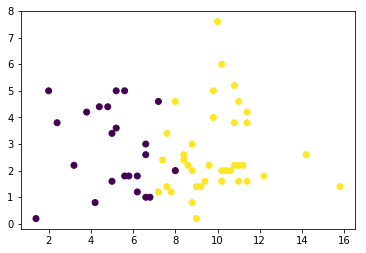

In [208]:
plt.scatter(X['u1_speak'],X['u2_speak'],c=kmean.labels_)

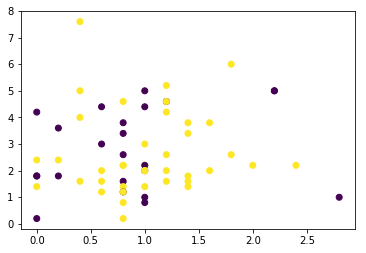

In [209]:
plt.scatter(X['u3_speak'],X['u2_speak'],c=kmean.labels_)

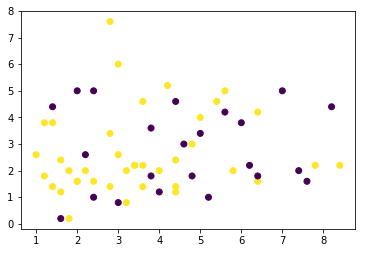

In [210]:
plt.scatter(X['u4_speak'],X['u2_speak'],c=kmean.labels_)

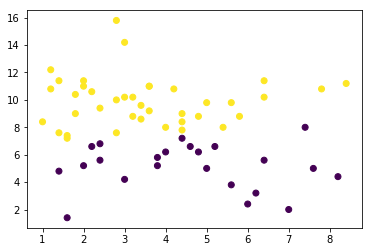

In [211]:
plt.scatter(X['u4_speak'],X['u1_speak'],c=kmean.labels_)

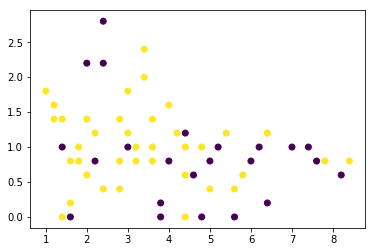

In [212]:
plt.scatter(X['u4_speak'],X['u3_speak'],c=kmean.labels_)

1.Smith, J., Bratt, H., Richey, C., Bassiou, N., Shriberg, E., Tsiartas, A., … Alozie, N. (2016). Spoken interaction modeling for automatic assessment of collaborative learning. Proceedings of the International Conference on Speech Prosody, 2016-Janua, 277–281. https://doi.org/10.21437/SpeechProsody.2016-57